# Nieve MODIS
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __04/12/2020__ <br>

__Introducción__<br>
Datos de MODIS sobre cobertura de nieve en la cuenca del Deva. 
1. Se cargan los datos originales (8 días) y se agregan a diversas frecuencias temporales (mensual y anual). Los datos se muestran en mapas y series.
2. Introducción al análisis de EOFs sobre los datos anteriores.

__Cosas que arreglar__ <br>
Cómo leer atributos del archivo _hdf_ de MODIS.

***

__Índice__ <br>
__[Datos](#Datos)__<br>
[DEM de la cuenca](#DEM-de-la-cuenca-(ETRS89-UTM30N))<br>
[Evapotranspiración MODIS](#Evapotranspiración-MODIS)<br>

__[Análisis](#Análisis)__<br>
[8 diario](#8-diario)<br>
[Mensual](#Mensual)<br>
[Anual](#Anual)<br>
[EOF](#EOF)<br>

In [1]:
import os
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, BoundaryNorm
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
from calendar import monthrange
import time
import geopandas as gpd
import matplotlib.patheffects as pe
import matplotlib.animation as animation
from IPython.display import HTML
from pyproj import Proj, transform, CRS
#os.environ['PROJ_LIB'] = r'C:\Anaconda3\pkgs\proj4-4.9.3-vc14_5\Library\share'

In [3]:
os.chdir(rutaBase + '../../../MODIS/py/')
from funciones_MODIS import *
#from funciones_EOF import *
os.chdir(rutaBase)

In [4]:
os.chdir(rutaBase + '../../py')
#from class_MODIS import *
from funciones_raster import *

## 1 Cartografía

In [5]:
# ruta cartografía
#rutaGIS = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Proyectos/IAHR2020/GIS/'
rutaGIS = os.path.join(rutaBase, '../../data/GIS/')

# importar polígonos de las cuencas
cuenca = gpd.read_file(rutaGIS + "mask_465_deva.shp")

# importar mdt de la cuenca
DEM = read_ascii(rutaGIS + 'dem_465_deva.asc', crs=25830)
DEM.variable = 'elevación'
DEM.units = 'm.s.n.m'

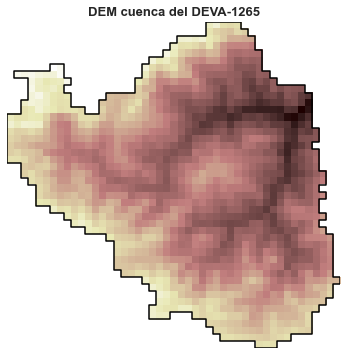

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

cuenca.boundary.plot(ax=ax, edgecolor='k')
ax.imshow(DEM.data, cmap='pink', extent=DEM.extent)

ax.set_title('DEM cuenca del DEVA-1265', fontsize=13, fontweight='bold')
ax.set_aspect('equal')
ax.axis('off');

## 2 Datos MODIS: Terra y Aqua

### 2.1 Cargar datos brutos

In [7]:
# rutas de entrada y salida
rutaMODIS = 'C:/Users/jcr693/OneDrive - UNICAN - Estudiantes/Cartografia/MODIS/'

In [8]:
# parámetros de la extracción de datos de MODIS
products = {'Terra': 'MOD10A2', 'Aqua': 'MYD10A2'}
var = 'Maximum_Snow_Extent'
units = '-'
dateslim = ('2005-10-01', '2015-09-30')#None
tiles = ['h17v04']

In [9]:
# definir extensión a extraer de MODIS
left, bottom, right, top = cuenca.to_crs(sinusoidal).bounds.loc[0,:]
cellsize = DEM.cellsize
extent = [left - cellsize, right + cellsize, bottom - cellsize, top + cellsize]

SC = {}
for sat in products:
    print(sat.upper())
    print('-' * len(sat))
    product = products[sat]

    # extraer datos de MODIS
    modis = MODIS_extract(rutaMODIS, product, var, tiles, dateslim=dateslim,
                          extent=extent, verbose=True)

    # reproyectar a UTM-30N según el vecino más cercano
    modis.reproyectar(DEM.crs, cellsize, n_neighbors=1, weights='distance', p=1,
                      snap=DEM, inplace=True)

    # recortar a la cuenca
    modis.recortar(cuenca, buffer=10, inplace=True)

    # guardar datos como clase MODIS
    SC[sat] = modis

    print('\n')    

TERRA
-----
Seleccionar archivos
nº de archivos (fechas): 460

Generar atributos globales
dimensión:		(2400, 2400)
esquina inf. izqda.:	(-1111950.52, 4447802.08)
esquina sup. dcha.:	(      0.00, 5559752.60)

Crear máscaras
dimensión:		(  48,   49)
esquina inf. izqda.:	(-394443.47, 4782916.80)
esquina sup. dcha.:	(-372195.19, 4804701.58)

Importar datos
Fecha 460 de 460: 2015-09-30	||	Tile  1 de  1: h17v04
Paso 460 de 460:	2015-09-30

AQUA
----
Seleccionar archivos
nº de archivos (fechas): 460

Generar atributos globales
dimensión:		(2400, 2400)
esquina inf. izqda.:	(-1111950.52, 4447802.08)
esquina sup. dcha.:	(      0.00, 5559752.60)

Crear máscaras
dimensión:		(  48,   49)
esquina inf. izqda.:	(-394443.47, 4782916.80)
esquina sup. dcha.:	(-372195.19, 4804701.58)

Importar datos
Fecha 460 de 460: 2015-09-30	||	Tile  1 de  1: h17v04
Paso 460 de 460:	2015-09-30



### 2.2 Exportar datos brutos

In [10]:
# ruta y archivo donde guardar los datos extraios
rutaExport = os.path.join(rutaBase, '../data/')
if os.path.exists(rutaExport) == False:
    os.makedirs(rutaExport)
filename = 'MODIS_' + var + '.nc'

In [11]:
# definir el netcdf
ncMODIS = Dataset(rutaExport + filename, 'w', format='NETCDF4')

# crear grupos
terra = ncMODIS.createGroup('Terra')
aqua = ncMODIS.createGroup('Aqua')

# crear atributos
ncMODIS.description = 'Serie temporal de mapas de SC de la cuenca del Deva obtenidos a partir de MODIS'
ncMODIS.history = 'Creado el ' + datetime.now().date().strftime('%Y-%m-%d')
ncMODIS.source = 'https://e4ftl01.cr.usgs.gov/'
ncMODIS.coordinateSystem = 'epsg:{0}'.format(modis.crs.to_epsg()) # 'SINUSOIDAL'

for group, sat, product in zip([terra, aqua], ['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
    # crear las dimensiones
    time = group.createDimension('time', len(SC[sat].times))
    Y = group.createDimension('Y', len(SC[sat].Y))
    X = group.createDimension('X', len(SC[sat].X))

    # crear variables
    Var = group.createVariable(product, 'f4', ('time', 'Y', 'X'))
    Var.units = units
    times = group.createVariable('time', 'f8', ('time',))
    times.units = 'días desde el 0001-01-01'
    times.calendar = 'Gregoriano'
    Xs = group.createVariable('X', 'u4', ('X',))
    Xs.units = 'm'
    Ys = group.createVariable('Y', 'u4', ('Y',))
    Ys.units = 'm'

    # variable SC
    Var[:,:,:] = SC[sat].data[:,:,:]
    # variable 'time'
    deltas = [date - datetime(1, 1, 1).date() for date in SC[sat].times]
    times[:] = [delta.days for delta in deltas]
    # variable 'X'
    Xs[:] = SC[sat].X # + cellsize / 2
    # variable 'Y'
    Ys[:] = SC[sat].Y # + cellsize / 2

ncMODIS.close()

## 3 Tratamiento de datos
### 3.1 Importar datos

In [12]:
# Cargar netcdf con los datos MODIS
nc = Dataset(rutaExport + filename, 'r', format='NETCDF4')
#print(nc)

# extraer datos en un diccionario
SC = {}
for sat, product in zip(['Terra', 'Aqua'], ['MOD16A2', 'MYD16A2']):
    # evapotranspiración
    data = nc[sat][product][::].data
    units = nc[sat][product].units
    # fechas
    times = np.array([datetime(1, 1, 1).date() + timedelta(time) for time in nc[sat]['time'][:].data])
    # coordenadas
    X = nc[sat]['X'][:].data
    Y = nc[sat]['Y'][:].data
    crs = CRS.from_epsg(nc.coordinateSystem.split(':')[1])
    
    # guardar como objeto raster3D
    SC[sat] = raster3D(data, X, Y, times, variable='snow cover', label='SC', units=units,
                       crs=crs)
    SC[sat].enmascararNaN()

nc.close()

### 3.2 Reclasificar
Se convierten los datos de covertura de nieve en un mapa binario de presencia-ausencia de nieve. Para ello se convierten en __NaN__ todos las clases dudosas (missing data, no decision, night, lake, ocean, cloud, lake ice, detector saturated), en __1__ las presencias (snow) y en __0__ las ausencias de nieve (no snow).

In [13]:
# clases en los mapas de cobertura de nieve de MODIS
snowClass = {0: 'missing data',
             1: 'no decision',
             11: 'night',
             25: 'no snow',
             37: 'lake',
             39: 'ocean',
             50: 'cloud',
             100: 'lake ice',
             200: 'snow',
             254: 'detector saturated',
             255: 'fill'}

In [14]:
# nº de celdas en cada una de las clases
for sat in SC:
    print(sat.upper())
    print('-'*len(sat))
    data = SC[sat].data
    for clase in snowClass:
        print('{0}: {1}'.format(snowClass[clase], np.sum(data == clase)))
    print()

TERRA
-----
missing data: 0
no decision: 1
night: 0
no snow: 452049
lake: 0
ocean: 0
cloud: 50253
lake ice: 0
snow: 116857
detector saturated: 0
fill: 0

AQUA
----
missing data: 0
no decision: 1
night: 0
no snow: 434745
lake: 0
ocean: 0
cloud: 57212
lake ice: 0
snow: 127202
detector saturated: 0
fill: 0



In [15]:
# reclasificar mapas
for sat in SC:
    
    data = SC[sat].data
    # convertir en nan datos sin interés
    for clase in [0, 1, 11, 50, 254, 255]:
        data[data == clase] = np.nan
    # convertir en 1 las presencias
    data[data == 200] = 1
    # convertir en 0 las ausencias
    data[data == 25] = 0
    SC[sat].data = data

### 3.3 Unificar datos de Terra y Aqua

In [16]:
# extraer datos de Terra y Aqua
terra = SC['Terra'].data
aqua = SC['Aqua'].data

# partiendo de los datos de Terra
mix = terra.copy()

# se añaden los datos de Aqua donde Terra tenga NaN
maskAqua = np.isnan(terra) & ~np.isnan(aqua)
mix[maskAqua] = aqua[maskAqua]

# definir objeto raster3D
SCobs = raster3D(mix, SC['Terra'].X, SC['Terra'].Y, SC['Terra'].times, SC['Terra'].units,
                variable='observed snow cover', label='SCobs', crs=SC['Terra'].crs)

2007-01-25


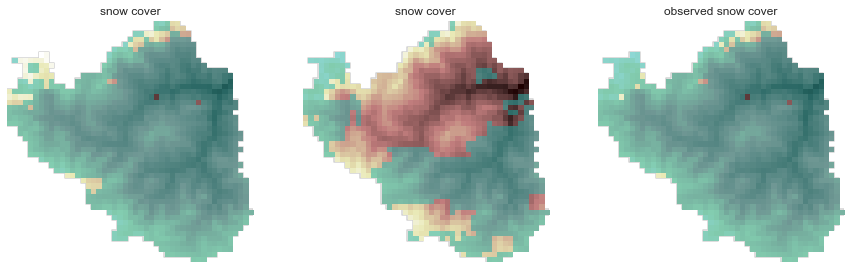

In [17]:
t = 60
time = SCobs.times[t]
print(time)

# definir colores
colors = np.array([[255, 255, 255 , 0], [33, 178, 171, 130]])
colors = colors / 255.
cmap_snow = ListedColormap(colors)
boundaries = [0, .5, 1]
norm = BoundaryNorm(boundaries, cmap_snow.N, clip=True)
snow_patch = mpatches.Patch(color=cmap_snow.colors[1], label='snow')

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for ax, Var in zip(axes, [SC['Terra'], SC['Aqua'], SCobs]):
    cuenca.boundary.plot(color='lightgray', ax=ax, zorder=0)
    ax.imshow(DEM.data, extent=DEM.extent, cmap='pink')
    ax.imshow(Var.data[t,:,:], extent=Var.extent(), cmap=cmap_snow, norm=norm)
    #Var.plot(time=time, ax=ax)
    ax.set_title(Var.variable)
    ax.axis('off')

### 3.4 Exportar datos tratados

In [18]:
filename = 'MODIS_Maximum_Snow_Extent_Terra+Aqua.nc'

In [19]:
# definir el netcdf
ncMODIS = Dataset(rutaExport + filename, 'w', format='NETCDF4')

# crear atributos
ncMODIS.description = 'Serie temporal de mapas de SC de la cuenca del Deva obtenidos a partir de MODIS'
ncMODIS.history = 'Creado el ' + datetime.now().date().strftime('%Y-%m-%d')
ncMODIS.source = 'https://e4ftl01.cr.usgs.gov/'
ncMODIS.coordinateSystem = 'epsg:{0}'.format(modis.crs.to_epsg()) # 'SINUSOIDAL'

# crear las dimensiones
time = ncMODIS.createDimension('time', len(SCobs.times))
Y = ncMODIS.createDimension('Y', len(SCobs.Y))
X = ncMODIS.createDimension('X', len(SCobs.X))

# crear variables
Var = ncMODIS.createVariable('SC', 'f4', ('time', 'Y', 'X'))
Var.units = units
times = ncMODIS.createVariable('time', 'f8', ('time',))
times.units = 'días desde el 0001-01-01'
times.calendar = 'Gregoriano'
Xs = ncMODIS.createVariable('X', 'u4', ('X',))
Xs.units = 'm'
Ys = ncMODIS.createVariable('Y', 'u4', ('Y',))
Ys.units = 'm'

# variable SC
Var[:,:,:] = SCobs.data[:,:,:]
# variable 'time'
deltas = [date - datetime(1, 1, 1).date() for date in SCobs.times]
times[:] = [delta.days for delta in deltas]
# variable 'X'
Xs[:] = SCobs.X # + cellsize / 2
# variable 'Y'
Ys[:] = SCobs.Y # + cellsize / 2

ncMODIS.close()

## 4 Vídeo

In [20]:
# definir límites del mapa
xmin, ymin, xmax, ymax = cuenca.bounds.values[0]
xmin -= cellsize * 2
ymin -= cellsize * 2
xmax += cellsize * 2
ymax += cellsize * 2
extent = [xmin, xmax, ymin, ymax]

In [21]:
# video(SC['Terra'], cuenca, cmap, norm, DEM, figsize=(6, 6), extent=extent)

Exportando archivo C:/Users/jcr693/Documents/GitHub/Calibrar/Nieve/notebooks/../output/SC_Terra_Aqua.mp4


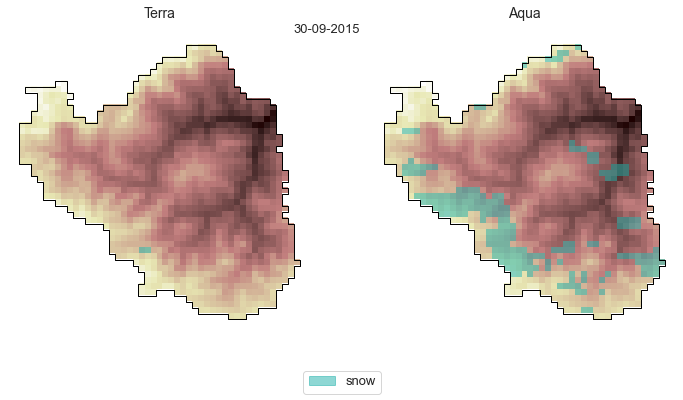

In [22]:
rutaOut = os.path.join(rutaBase, '../output/')
mp4File = rutaOut + 'SC_Terra_Aqua.mp4'
video2(SC['Terra'], SC['Aqua'], cuenca, cmap_snow, norm, DEM, fps=3, dpi=300, ax=axes[0], figsize=(12, 6), extent=extent,
       labels=['Terra', 'Aqua'], export=mp4File)